In [10]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [11]:
datapath = os.path.join('../', 'data')
filterpath = os.path.join(datapath, '8_19')
num_filters = 8

In [12]:
def get_joint_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file))
    weight_dataset.append(filter['0.weight'])
  return torch.stack(weight_dataset)

In [13]:
joint_dataset = get_joint_dataset()

1364it [00:02, 459.98it/s] 


In [14]:
def get_dataset_from_joint_dataset(joint_dataset):
    dataset = []
    for i in range(len(joint_dataset)):
        for j in range(num_filters):
            dataset.append(joint_dataset[i][j][0])
    return torch.stack(dataset)

In [15]:
dataset = get_dataset_from_joint_dataset(joint_dataset)

In [16]:
torch.max(dataset)

tensor(1.6230, device='cuda:0')

In [17]:
vmin, vmax = -2.5, 2.5

In [18]:
def visualise_joint(num_rows):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))
  plt.axis('off')
  uuids = os.listdir(filterpath)
  for f in range(num_rows):
    file = np.random.choice(uuids, replace=True)
    filter = torch.load(os.path.join(filterpath, file))
    for i in range(num_filters):
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter['0.weight'][i][0].detach().cpu(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))
        # axarr[f, i].colorbar()
  return filter

In [19]:
# t = np.zeros((50, 50))
# t[10, 10] = 1
# t[10, 20] = 2
# plt.imshow(t, norm=matplotlib.colors.Normalize(vmin=0, vmax=2, clip=False))
# plt.colorbar()

Visualising all filters (joint sampling)

5471


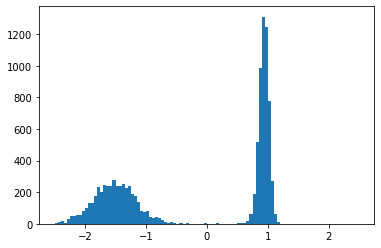

In [78]:
import matplotlib
def histogram_sampled_joint(num_samples):

    vals = []
    uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in range(num_samples):
        file = np.random.choice(uuids, replace=True)
        filter = torch.load(os.path.join(filterpath, file))
#         idx = np.random.choice(8)
        for idx in range(num_filters):
            vals.append(np.mean(filter['0.weight'][idx][0].detach().cpu().numpy()))
            if vals[-1] > 0:
                num_over_0 += 1
    plt.hist(vals, bins=100,range=(-2.5,2.5))
    print(num_over_0)


histogram_sampled_joint(1250)

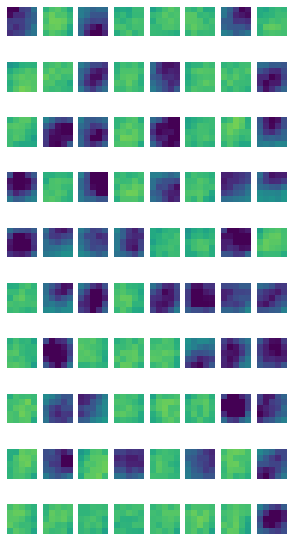

In [20]:
num_images = len(os.listdir(filterpath))
sample_filter = visualise_joint(10)

In [21]:
sample_filter['0.weight'][7]

tensor([[[-0.3649, -0.9604, -1.4754, -1.7332, -1.0729],
         [-1.0017, -1.8675, -2.6804, -2.9809, -2.1513],
         [-1.4446, -2.5312, -3.8343, -3.2274, -2.1177],
         [-1.1701, -2.3537, -2.6865, -2.0888, -1.4640],
         [-0.8413, -1.0964, -1.4515, -1.6124, -1.3106]]], device='cuda:0')

Visualising IID sampled filters

In [57]:
import matplotlib
def visualise_sampled_IID(num_rows):
    _, axarr = plt.subplots(num_rows, 8, figsize=(int(5*(num_filters//8)), num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        for i in range(8):
            file = np.random.choice(uuids, replace=True)
            filter = torch.load(os.path.join(filterpath, file))
            idx = np.random.choice(8)
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(filter['0.weight'][idx][0].detach().cpu(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

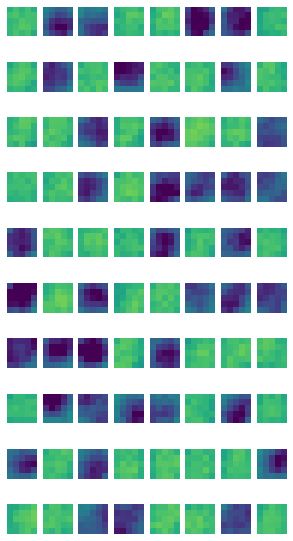

In [58]:
visualise_sampled_IID(10)

5466


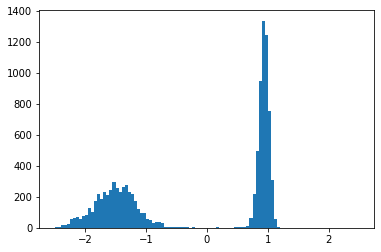

In [59]:
import matplotlib
def histogram_sampled_IID(num_samples):

    vals = []
    uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in range(num_samples):
        file = np.random.choice(uuids, replace=True)
        filter = torch.load(os.path.join(filterpath, file))
        idx = np.random.choice(8)
        vals.append(np.mean(filter['0.weight'][idx][0].detach().cpu().numpy()))
        if vals[-1] > 0:
            num_over_0 += 1
    plt.hist(vals, bins=100,range=(-2.5,2.5))
    print(num_over_0)


histogram_sampled_IID(10000)

Visualising VAE sampled filters

In [25]:
import torch
import torch.nn as nn

vae_batch_size = 100
x_dim  = 25
hidden_dim1 = 20
hidden_dim2 = 20
hidden_dim3 = 20
hidden_dim4 = 20
latent_dim = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [64]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim1)
        self.FC_input2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_input3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_input4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_mean  = nn.Linear(hidden_dim2, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim2, latent_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        self.training = True
        
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        h_       = self.tanh(self.FC_input3(h_))
        h_       = self.tanh(self.FC_input4(h_))

        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim1)
        self.FC_hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_hidden4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_output = nn.Linear(hidden_dim4, output_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        h     = self.tanh(self.FC_hidden(x))
        h     = self.tanh(self.FC_hidden2(h))
        h     = self.tanh(self.FC_hidden3(h))
        h     = self.tanh(self.FC_hidden4(h))

        x_hat = self.FC_output(h)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        # self.lamb = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [65]:
model.load_state_dict(torch.load('../data/vae_8.pt'))
model.eval()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=25, out_features=20, bias=True)
    (FC_input2): Linear(in_features=20, out_features=20, bias=True)
    (FC_input3): Linear(in_features=20, out_features=20, bias=True)
    (FC_input4): Linear(in_features=20, out_features=20, bias=True)
    (FC_mean): Linear(in_features=20, out_features=10, bias=True)
    (FC_var): Linear(in_features=20, out_features=10, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=10, out_features=20, bias=True)
    (FC_hidden2): Linear(in_features=20, out_features=20, bias=True)
    (FC_hidden3): Linear(in_features=20, out_features=20, bias=True)
    (FC_hidden4): Linear(in_features=20, out_features=20, bias=True)
    (FC_output): Linear(in_features=20, out_features=25, bias=True)
    (tanh): Tanh()
  )
)

In [66]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)
    # net[0].weight[c,:,:,:] = generated_filter[0].view(5, 5)


In [29]:
def show_image(x, idx):
    x = x.view(vae_batch_size, 5, 5)
    fig = plt.figure()
    print(x[idx])
    plt.imshow(x[idx].cpu().numpy())

In [30]:
torch.max(generated_images[1])

tensor(1.2352, device='cuda:0')

tensor([[0.6404, 0.8437, 0.9642, 0.9720, 0.8073],
        [0.8324, 1.0104, 1.0977, 1.0907, 0.9486],
        [0.9133, 1.1127, 1.1212, 1.1085, 0.9143],
        [0.9537, 1.1053, 1.1336, 1.0056, 0.7400],
        [0.8172, 0.9567, 0.9609, 0.7914, 0.5677]], device='cuda:0')


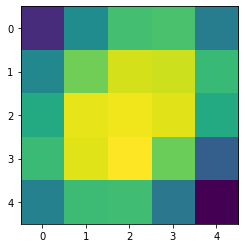

In [31]:
show_image(generated_images, idx=12)

In [32]:
def visualise_vae(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 5, 5)

  for i in range(num_rows):
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[num_filters*i+j].cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

100%|██████████| 10000/10000 [00:03<00:00, 2932.42it/s]


4922


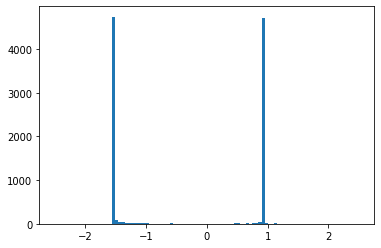

In [69]:
def histogram_vae(num_samples):

    vals = []
#     uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in tqdm(range(num_samples)):
        noise = torch.randn(1, latent_dim).to(device)
        generated_images =  model.Decoder(noise)
        
#         file = np.random.choice(uuids, replace=True)
        filter = generated_images.view(5,5)
#         idx = np.random.choice(8)
        vals.append(np.mean(filter.detach().cpu().numpy()))
        if vals[-1] > 0:
            num_over_0 += 1
    plt.hist(vals, bins=100,range=(-2.5,2.5))
    print(num_over_0)


histogram_vae(10000)

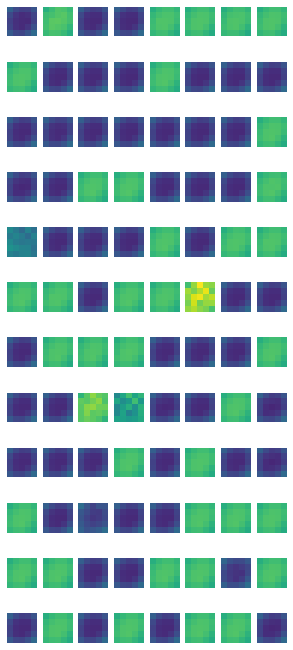

In [33]:
visualise_vae(100//num_filters, generated_images)

In [34]:
def visualise_random(num_rows):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  for i in range(num_rows):
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      val = (vmin - vmax) * torch.rand(5, 5) + vmax
      axarr[i, j].imshow(val.cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

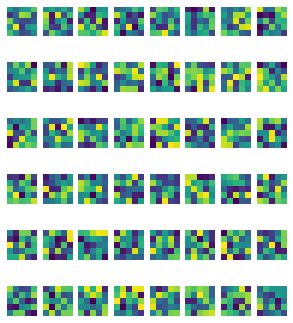

In [35]:
visualise_random(6)

4978


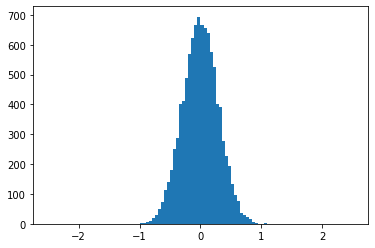

In [62]:
import matplotlib
def histogram_random(num_samples):

    vals = []
    uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in range(num_samples):
        file = np.random.choice(uuids, replace=True)
        filter = (vmin - vmax) * torch.rand(5, 5) + vmax
        idx = np.random.choice(8)
        vals.append(np.mean(filter.detach().cpu().numpy()))
        if vals[-1] > 0:
            num_over_0 += 1
    plt.hist(vals, bins=100,range=(-2.5,2.5))
    print(num_over_0)


histogram_random(10000)

LSTM VAE Viz

In [79]:
loadpath = os.path.join("../modeling/Sequence-VAE/models/filter_lstm/shuffle_100_recon_st.pt")
savepath = '../data/save_baselines_lstm_joint_' + str(num_filters) + '.pickle'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# bptt = 60
vae_batch_size = 100
# embed_size = 300
hidden_size = 20
latent_size = 10
# latent_dim = 10
input_size = 25

class LSTM_VAE(torch.nn.Module):

  def __init__(self, input_size, hidden_size, latent_size, num_layers=1):
    super(LSTM_VAE, self).__init__()

    self.device = "cuda" if torch.cuda.is_available() else "cpu"

    # Variables
    self.num_layers = num_layers
    self.lstm_factor = num_layers
    # self.vocab_size = vocab_size
    # self.embed_size = embed_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.latent_size = latent_size

    # For dictionary lookups 
    # self.dictionary = PTB(data_dir="./data", split="train", create_data= False, max_sequence_length= 60)
  
    # X: bsz * seq_len * vocab_size 
    # Embedding
    # self.embed = torch.nn.Embedding(num_embeddings= self.vocab_size,embedding_dim= self.embed_size)

    #    X: bsz * seq_len * vocab_size 
    #    X: bsz * seq_len * embed_size

    # Encoder Part
    self.encoder_lstm = torch.nn.LSTM(input_size= self.input_size,hidden_size= self.hidden_size, batch_first=True, num_layers= self.num_layers)
    self.mean = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.latent_size)
    self.log_variance = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.latent_size)

    # Decoder Part
                                        
    self.init_hidden_decoder = torch.nn.Linear(in_features= self.latent_size, out_features= self.hidden_size * self.lstm_factor)
    self.decoder_lstm = torch.nn.LSTM(input_size= self.input_size, hidden_size= self.hidden_size, batch_first = True, num_layers = self.num_layers)
    self.output = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.input_size)
    # self.log_softmax = torch.nn.LogSoftmax(dim=2)

  def init_hidden(self, batch_size):
    hidden_cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
    state_cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
    return (hidden_cell, state_cell)
#     return hidden_cell


  # def get_embedding(self, x):
  #   x_embed = self.embed(x)
    
  #   # Total length for pad_packed_sequence method = maximum sequence length
  #   maximum_sequence_length = x_embed.size(1)

  #   return x_embed, maximum_sequence_length

  def encoder(self, input_filters, hidden_encoder):

    # pad the packed input.
#     print(input_filters)
    output_encoder, hidden_encoder = self.encoder_lstm(input_filters, hidden_encoder)
#     output_encoder, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output_encoder, batch_first=True, total_length= total_padding_length)

    # Extimate the mean and the variance of q(z|x)
    mean = self.mean(hidden_encoder[0])
    log_var = self.log_variance(hidden_encoder[0])
    std = torch.exp(0.5 * log_var)   # e^(0.5 log_var) = var^0.5
    
    # Generate a unit gaussian noise.
    batch_size = output_encoder.size(0)
    seq_len = output_encoder.size(1)
    noise = torch.randn(batch_size, self.latent_size).to(self.device)
    
    z = noise * std + mean

    return z, mean, log_var, hidden_encoder


  def decoder(self, z, input_filters):

    hidden_decoder = self.init_hidden_decoder(z)
    hidden_decoder = (hidden_decoder, hidden_decoder)

    # pad the packed input.
    output_decoder, hidden_decoder = self.decoder_lstm(input_filters,hidden_decoder) 
#     output_decoder, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output_decoder, batch_first=True, total_length= total_padding_length)


    x_hat = self.output(output_decoder)
    
#     x_hat = self.log_softmax(x_hat)


    return x_hat

  

  def forward(self, input_filters,hidden_encoder):
    
    """
      x : bsz * seq_len
    
      hidden_encoder: ( num_lstm_layers * bsz * hidden_size, num_lstm_layers * bsz * hidden_size)

    """
    # Get Embeddings
    # x_embed, maximum_padding_length = self.get_embedding(x)

    # Packing the input
    # packed_x_embed = torch.nn.utils.rnn.pack_padded_sequence(input= x_embed, lengths= sentences_length, batch_first=True, enforce_sorted=False)


    # Encoder
    z, mean, log_var, hidden_encoder = self.encoder(input_filters, hidden_encoder)

    # Decoder
    x_hat = self.decoder(z, input_filters)
    


    return x_hat, mean, log_var, z, hidden_encoder

  

  def inference(self, batch_size, num_filters, filt1):

    # generate random z 
#     seq_len = 1


#     input = torch.Tensor(1, 1).fill_(self.dictionary.get_w2i()[sos]).long().to(self.device)
    
#         batch_size = 1
    out_filters = []
    for i in range(batch_size):
        z = torch.randn(1,1,self.latent_size).to(self.device)
        filter_samples = []
        input = filt1
        
        hidden = self.init_hidden_decoder(z)
        hidden = (hidden, hidden)

        for j in range(num_filters):
          output,hidden = self.decoder_lstm(input, hidden)
          output = self.output(output)
          filter_samples.append(output.view(-1))
          input = output
        
        out_filters.append(torch.stack(filter_samples, dim=0))
        
#     w_sample = [self.dictionary.get_i2w()[str(idx)] for idx in idx_sample]
#     w_sample = " ".join(w_sample)

    return torch.stack(out_filters, dim=0)

model = LSTM_VAE(input_size = input_size, hidden_size = hidden_size, latent_size = latent_size).to(device)
# MODEL_SAVE_PATH = "./models/filter_lstm/5000_Recon_st.pt"
model.load_state_dict(torch.load(loadpath))
model.eval()


cuda


LSTM_VAE(
  (encoder_lstm): LSTM(25, 20, batch_first=True)
  (mean): Linear(in_features=20, out_features=10, bias=True)
  (log_variance): Linear(in_features=20, out_features=10, bias=True)
  (init_hidden_decoder): Linear(in_features=10, out_features=20, bias=True)
  (decoder_lstm): LSTM(25, 20, batch_first=True)
  (output): Linear(in_features=20, out_features=25, bias=True)
)

In [80]:
num_samples = 8
vmin, vmax = -2.5, 2.5
def visualise_joint_from_tensor(filters, interv=1):
  num_rows = filters.shape[0]
  num_filters = filters.shape[1]
  _, axarr = plt.subplots(num_rows, num_filters//interv, figsize=(int(5*((num_filters//interv)//8)), num_rows))
  plt.axis('off')
  for f in range(num_rows):
    filter = filters[f]
    for x in range(0,num_filters,interv):
      i = x//interv
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter[x].detach().cpu(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))
  plt.show()  
  return filter

100%|██████████| 1250/1250 [00:16<00:00, 75.52it/s]


970


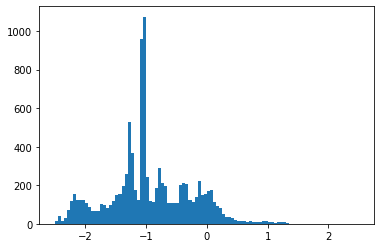

In [86]:
def histogram_lstm_joint(num_samples):

    vals = []
#     uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in tqdm(range(num_samples)):
        sample = model.inference(1,80,FILTER1.view(1,1,-1).to(device))
        sample = sample[:,::10]
#         print(generated_images.shape)
#         file = np.random.choice(uuids, replace=True)
        generated_images = sample.view(8,5,5)
#         idx = np.random.choice(8)
        for filter in generated_images:
#             print(filter.shape)
            vals.append(np.mean(filter.detach().cpu().numpy()))
            if vals[-1] > 0:
                num_over_0 += 1
    plt.hist(vals, bins=100,range=(-2.5,2.5))
    print(num_over_0)


# histogram_vae_joint(10000/8)
histogram_lstm_joint(1250)

In [85]:
sample = model.inference(num_samples,80,FILTER1.view(1,1,-1).to(device))
sample = sample[:,::10]
sample = sample.view(sample.shape[:-1]+tuple([5,5]))
sample.shape()

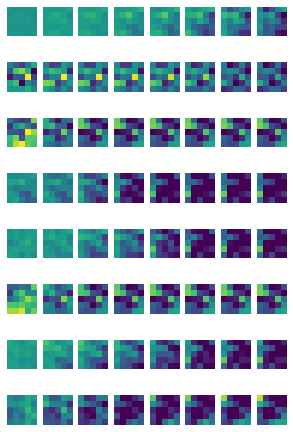

In [81]:
torch.manual_seed(1000)
num_samples = 8
FILTER1 = torch.zeros(5,5)
sample = model.inference(num_samples,80,FILTER1.view(1,1,-1).to(device))
sample = sample.view(sample.shape[:-1]+tuple([5,5]))
fils = visualise_joint_from_tensor(sample,10)

GMM Viz

In [70]:

import numpy as np
from sklearn.mixture import GaussianMixture

In [71]:
X = dataset.view(-1,25).detach().clone().cpu().numpy()

gmm = GaussianMixture(n_components=2).fit(X)

In [72]:
num_samples = 8
vmin, vmax = -2.5, 2.5
def visualise_filters(filters):
  num_rows = filters.shape[0]
  num_filters = filters.shape[1]
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))
  plt.axis('off')
  for f in range(num_rows):
    filter = filters[f]
    for i in range(num_filters):
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter[i], interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))
  plt.show()  
  return

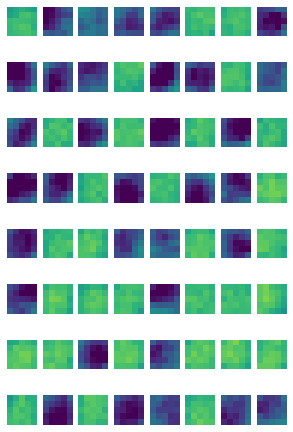

In [73]:
n_samples = 8
n_filters = 8
filters , _ = gmm.sample(n_filters*n_samples)
filters = np.random.permutation(np.reshape(filters, (-1,5,5)))
# print(components.sha)

filters = np.reshape(filters, (n_samples,n_filters,5,5))
visualise_filters(filters)

100%|██████████| 10000/10000 [00:09<00:00, 1082.58it/s]


5417


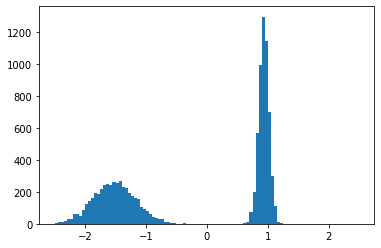

In [77]:
def histogram_gmm(num_samples):

    vals = []
#     uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in tqdm(range(num_samples)):
        generated_images,_ = gmm.sample(1)
        filter = np.reshape(generated_images,(5,5))
        vals.append(np.mean(filter))
        if vals[-1] > 0:
            num_over_0 += 1
    plt.hist(vals, bins=100,range=(-2.5,2.5))
    print(num_over_0)


histogram_gmm(10000)

# Looking at Results

In [36]:
import pickle
import numpy as np

In [37]:
files = ['joint', 'random', 'sampled_iid', 'vae']

In [38]:
res = {}
for file in files:
    with open('../data/save_baselines_' + file + '_file.pickle', 'rb') as f:
        res[file] = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/save_baselines_joint_file.pickle'

In [ ]:
d = res['joint']['joint_IID']['acc']
print('joint', np.mean(d), np.std(d))

joint 0.45455199999999996 0.12400282938707488


In [ ]:
d = res['sampled_iid']['sample_filters_IID_16']['acc']
print('sampled iid', np.mean(d), np.std(d))

sampled iid 0.477316 0.098790787748656


In [ ]:
d = res['random']['random_16']['acc']
print('random', np.mean(d), np.std(d))

random 0.17172 0.099667619616403


In [ ]:
d = res['vae']['vae_IID_16']['acc']
print('vae', np.mean(d), np.std(d))

vae 0.5837720000000001 0.06628210932069076


Visualize MNIST

In [ ]:
from torchvision import datasets, transforms

In [ ]:
mnist_mean, mnist_std = (0.1307,), (0.3081,)
mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
    ])
mnist_train = datasets.MNIST('../../data', train=True, download=True,
                    transform=mnist_transform)

In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True)

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data[0][0])
    break

In [116]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=8
ngpu=1
netG_load = '../dcgan-out/netG_epoch_990.pth'
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25),
            
            
            # EDITED


        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))



def visualise_dcgan(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[i].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-.3, vmax=.3, clip=False), interpolation=None)

def histogram_dcgan(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples // 8):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[i].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


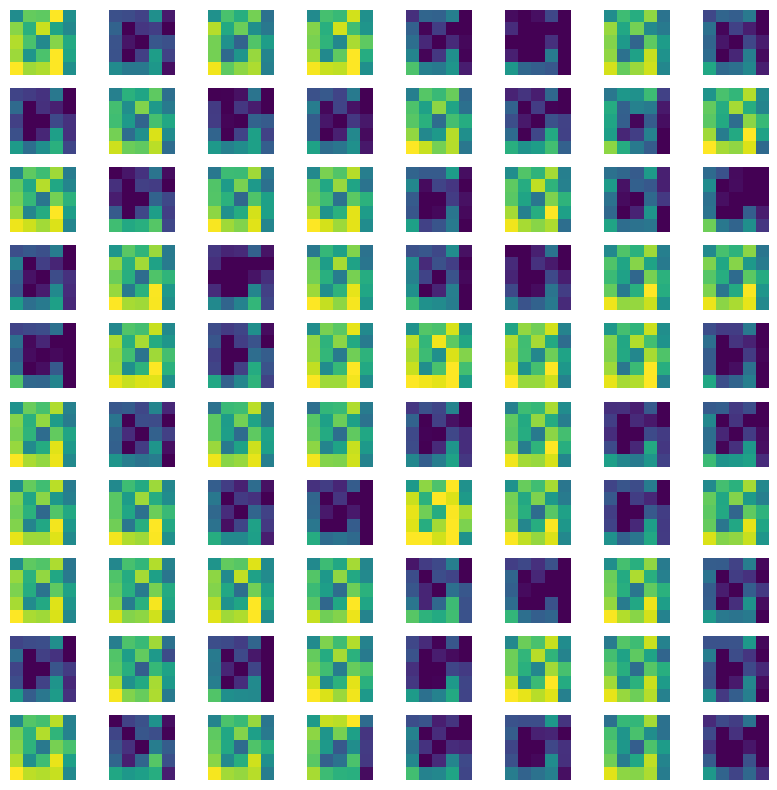

In [117]:

# histogram_dcgan(10000)
visualise_dcgan(netG, 10, nz)

In [4]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=32
nc = 8
ngpu=1
netG_load = '../dcgan-out/netG_epoch_990.pth'
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25 * 8),
            
            
            # EDITED


        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))



def visualise_dcgan_joint(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(2, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[0,i*25:i*25 + 25].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-.3, vmax=.3, clip=False), interpolation=None)

def histogram_dcgan_joint(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples):
        noise = torch.randn(2, nz, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[0,i*25:i*25 + 25].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


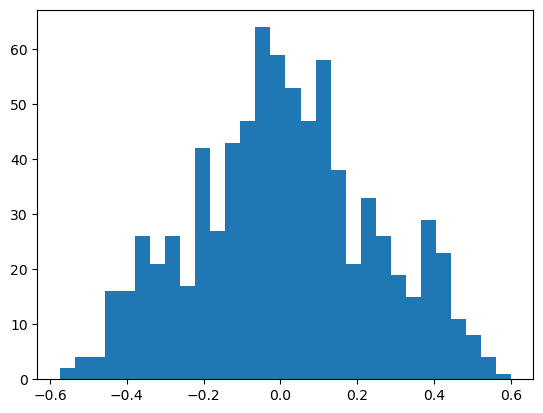

In [5]:
histogram_dcgan_joint(100)